In [1]:
# UPORABNO:
# Povezava: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [3]:
## knjižnice:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA

In [4]:
## podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=';')
podatki["DateTimeStartCET"] = pd.to_datetime(podatki["DateTimeStartCET"], format="%d.%m.%Y %H:%M")

podatki['Odjem ACT'] = podatki['Odjem ACT'].str.replace(',','.').astype(np.float64)

podatki = podatki.set_index('DateTimeStartCET')
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date

podatki

,DateTimeStartUTC,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day
DateTimeStartCET,,,,,,,,,
2021-11-01 00:00:00,31.10.2021 23:00,0.951,3.jun,5.mar,0,0,2021,11,2021-11-01
2021-11-01 00:15:00,31.10.2021 23:15,0.917,3.jun,5.mar,0,0,2021,11,2021-11-01
2021-11-01 00:30:00,31.10.2021 23:30,0.886,3.jun,5.mar,0,0,2021,11,2021-11-01
2021-11-01 00:45:00,31.10.2021 23:45,0.851,3.jun,5.mar,0,0,2021,11,2021-11-01
2021-11-01 01:00:00,1.11.2021 00:00,0.833,mar.45,5.mar,0,0,2021,11,2021-11-01
...,...,...,...,...,...,...,...,...,...
2024-02-29 22:45:00,29.02.2024 21:45,1.200,6.avg,7.475,0,0,2024,2,2024-02-29
2024-02-29 23:00:00,29.02.2024 22:00,1.130,jun.65,7.mar,0,0,2024,2,2024-02-29
2024-02-29 23:15:00,29.02.2024 22:15,1.080,6.maj,7.mar,0,0,2024,2,2024-02-29


In [5]:
## Številki opis podatkov:
df = pd.DataFrame([('Odjem', podatki['Odjem ACT'].min(), podatki['Odjem ACT'].max(), podatki['Odjem ACT'].mean(), podatki['Odjem ACT'].median(), podatki['Odjem ACT'].std())],
                    columns=(' ', 'Min', 'Max', 'Povprečje', 'Mediana', 'sd' ))
df

,,Min,Max,Povprečje,Mediana,sd
0,Odjem,0.000005,2.87,1.112501,1.12,0.518191


In [6]:
## Vizualizacija
sns.set(rc={'figure.figsize':(20, 5)}) # sets the default figure size

<AxesSubplot: xlabel='DateTimeStartCET'>

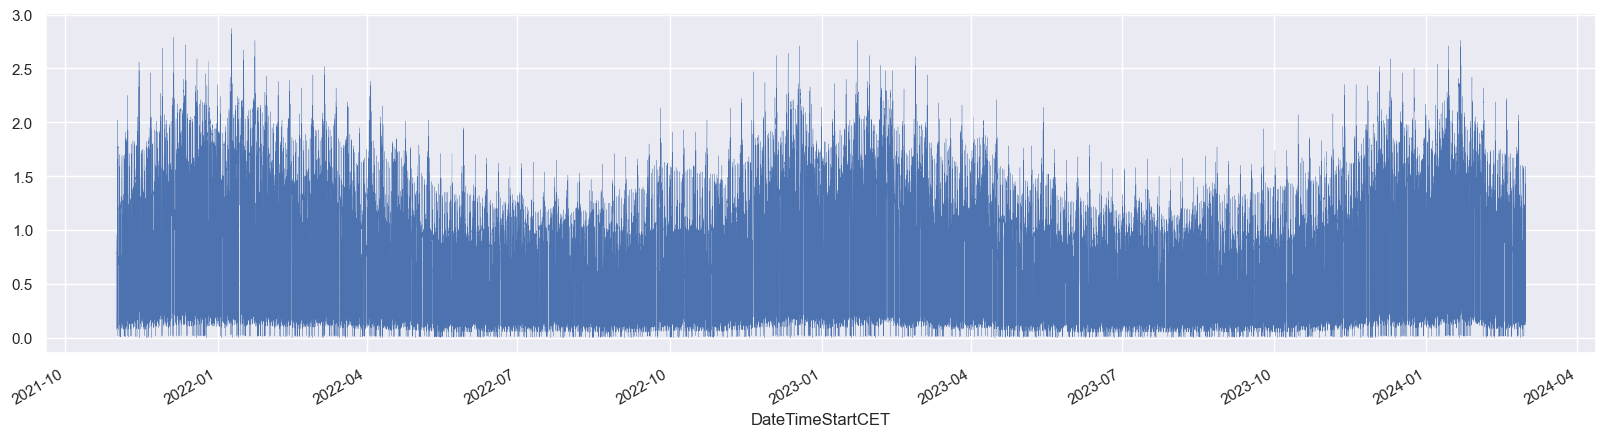

In [7]:
podatki['Odjem ACT'].plot(linewidth=0.2)

<AxesSubplot: xlabel='DateTimeStartCET'>

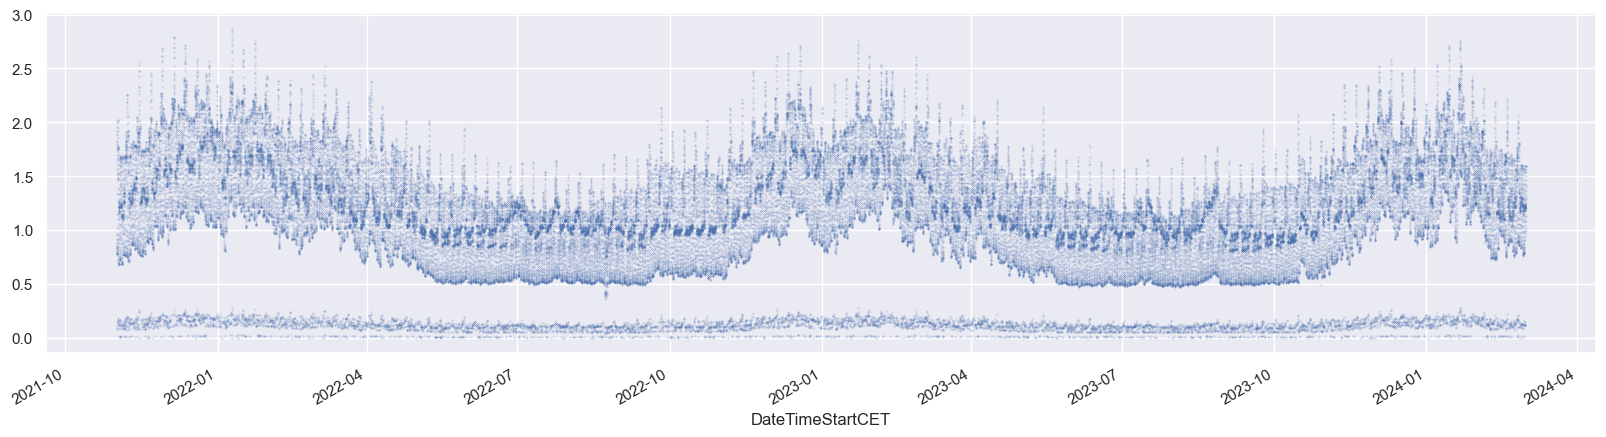

In [8]:
podatki['Odjem ACT'].plot(marker='.', alpha=0.5, linestyle='None', ms=0.5)
# iz tega grafa je malo boljše lažje razbrat stvari

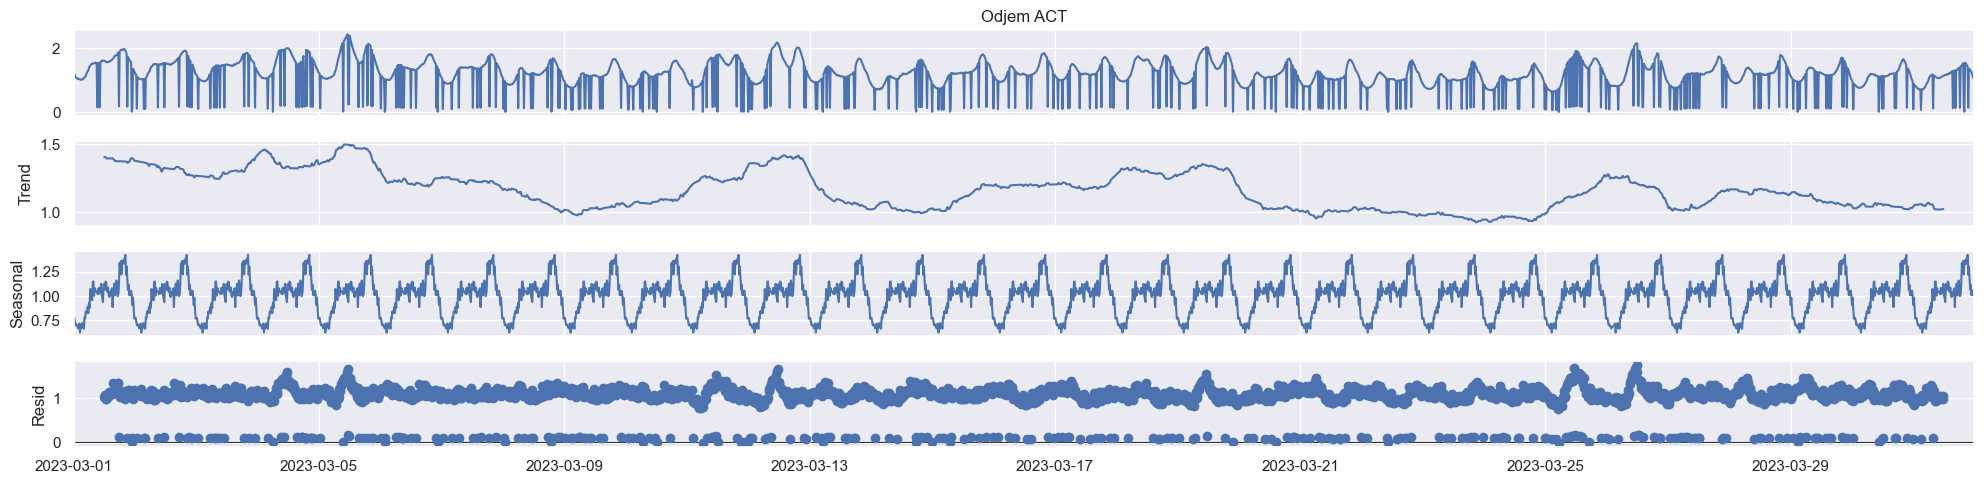

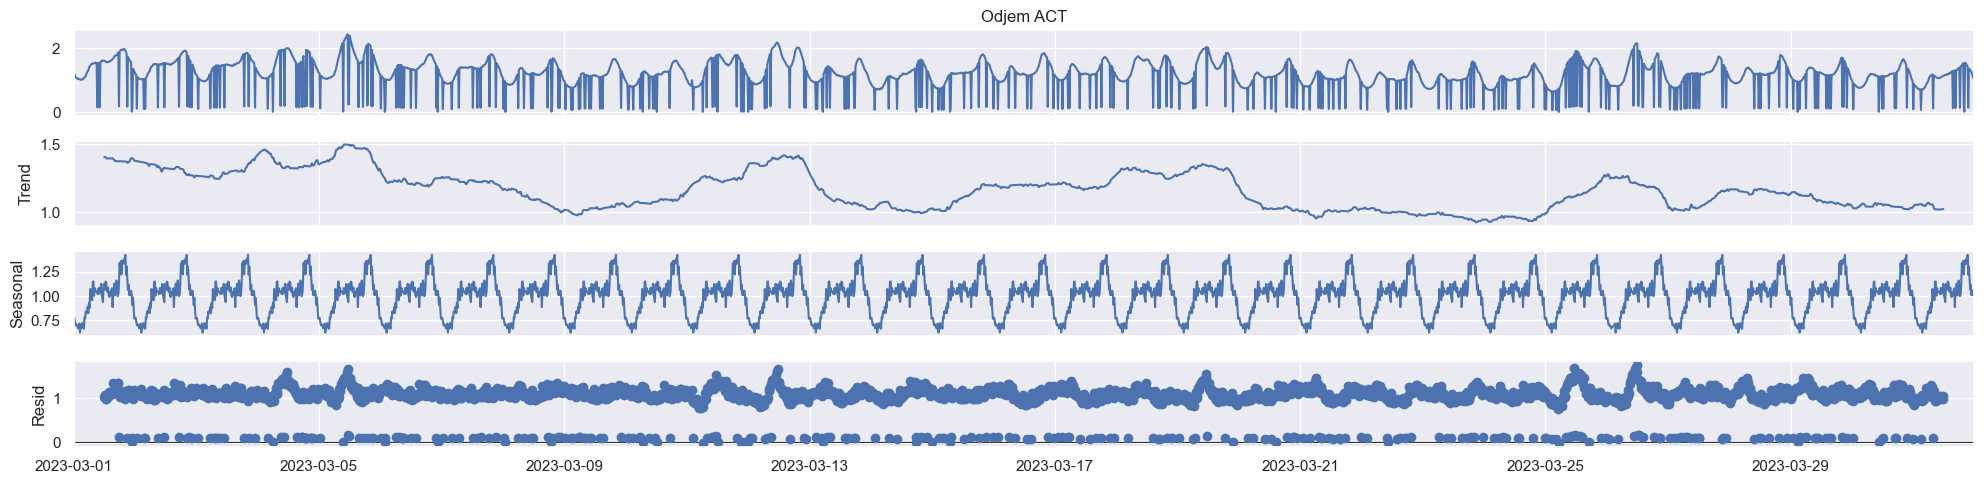

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

podatki_dec = podatki['Odjem ACT']
podatki_dec
decomp = seasonal_decompose(podatki.loc['2023-03', 'Odjem ACT'], model='multiplicative', period=96)
decomp.plot()

In [49]:
# opazke:
# - poraba je večja v zimskih mesecih
# - poraba se v času božičnih praznikov (konec decembra, začetek januarja) zmanjša
# - tisto kar je blizu nič predstavlja porabo tekom noči

<AxesSubplot: xlabel='DateTimeStartCET'>

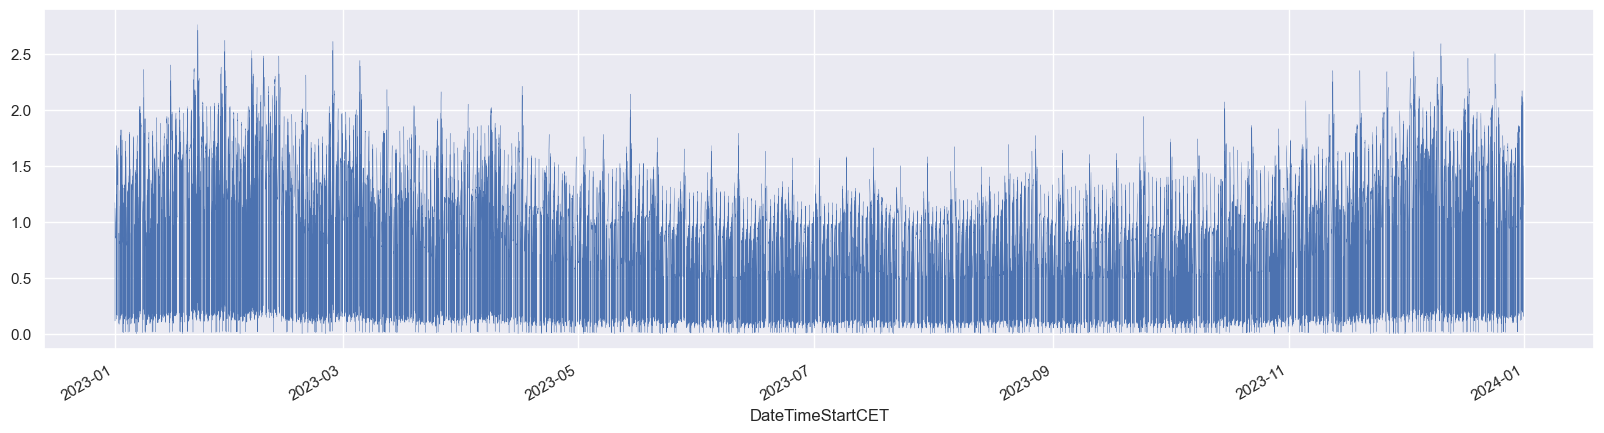

In [10]:
## odjem leta 2022:
podatki.loc['2023', 'Odjem ACT'].plot(linewidth=0.2)

<AxesSubplot: xlabel='DateTimeStartCET'>

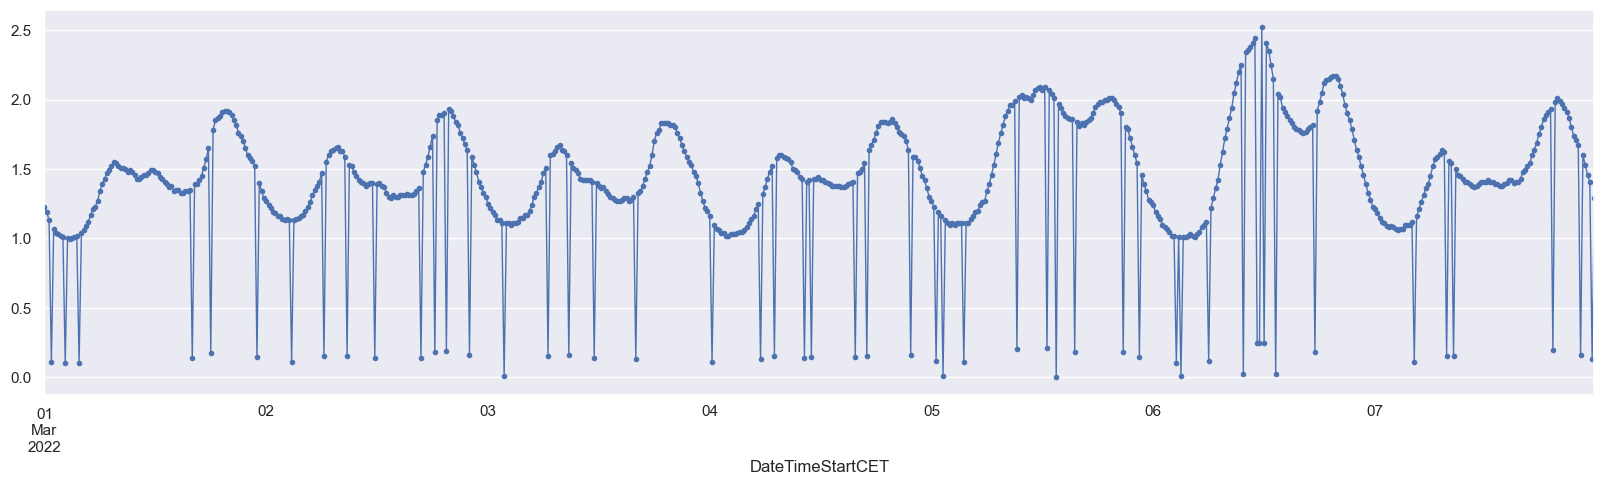

In [11]:
# odjem za en teden
podatki.loc['2022-03-01':'2022-03-07', 'Odjem ACT'].plot(marker='o', linestyle='-', linewidth=1, ms=3)

In [ ]:
## NAREDIMO ČASOVNO VRSTO STACIONARNO

# očitno je, da vrsta NI stacionarna

<AxesSubplot: xlabel='DateTimeStartCET'>

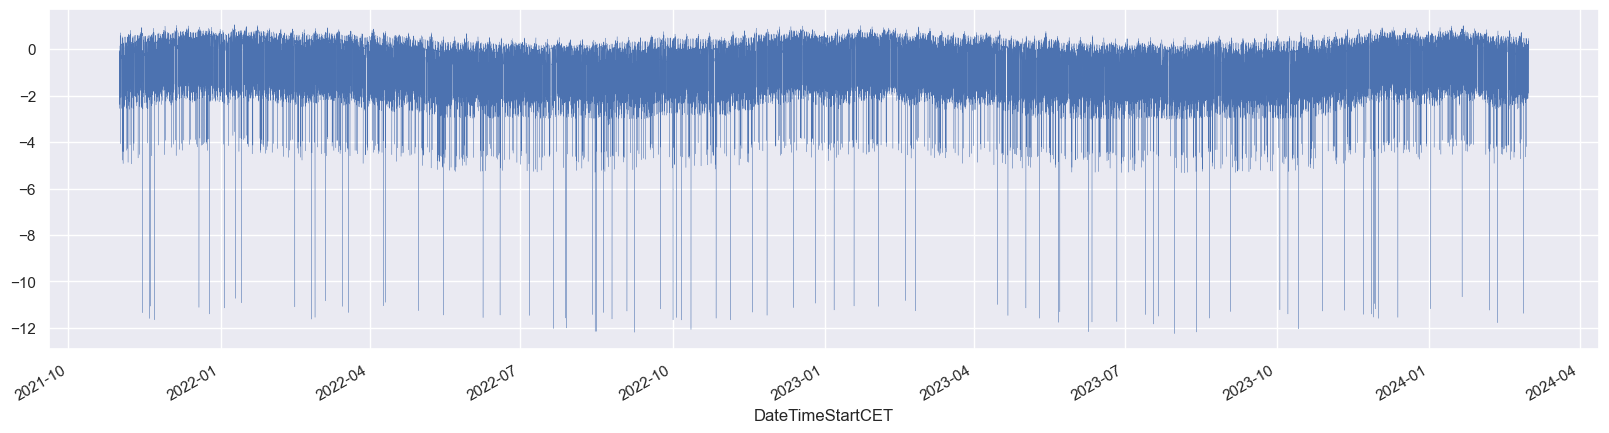

In [12]:
# Podatki so volatilni, zato najprej naredimo logaritemsko transformacijo (log(D_t)). Tako se vse malo bolj stabilizira 
podatki['Logaritem'] = np.log(podatki['Odjem ACT'])
podatki['Logaritem'].plot(linewidth=0.2)

Text(0.5, 1.0, 'Logaritem časovne vrste odjema, 2023')

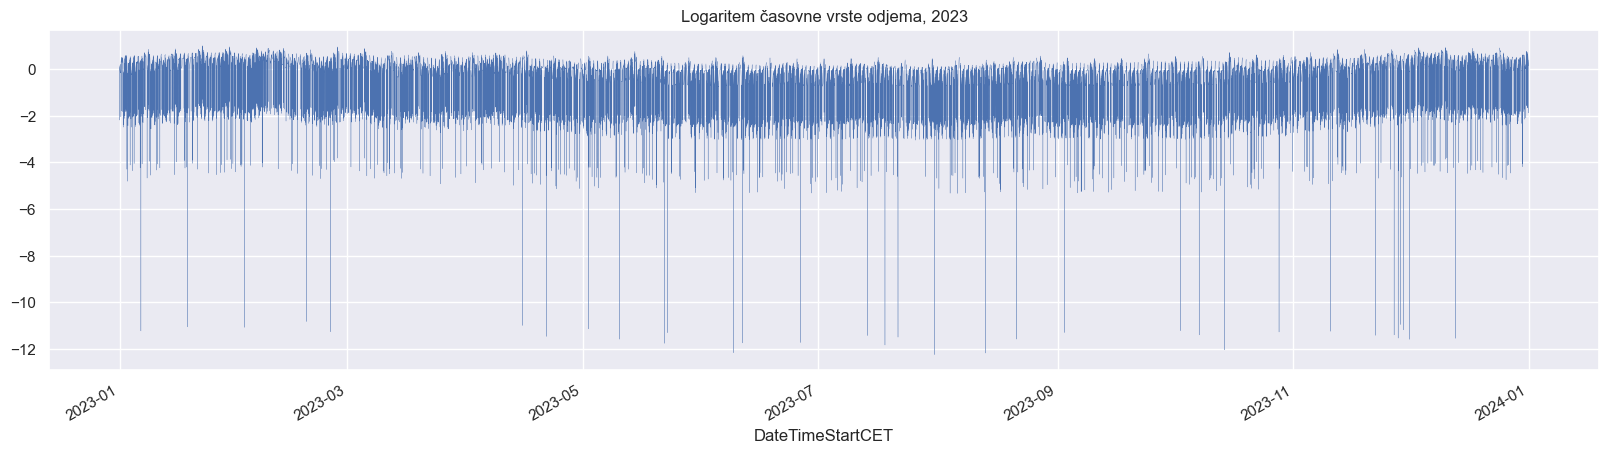

In [13]:
# zaradi velike količine podatkov, se bom osredotočala na leto 2023
podatki.loc['2023', 'Logaritem'].plot(linewidth=0.2) 
plt.title('Logaritem časovne vrste odjema, 2023')

Text(0.5, 1.0, 'ACF na logaritmu časovne vrste, 2023')

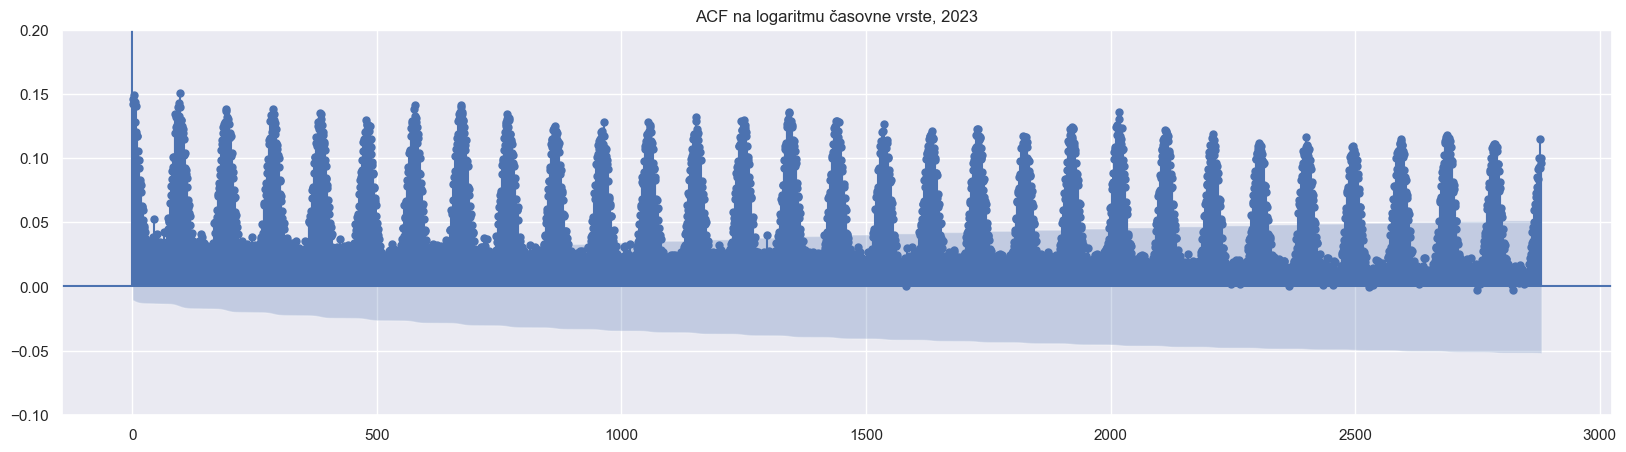

In [14]:
tsaplots.plot_acf(podatki.loc['2023', 'Logaritem'], lags=2880)
plt.ylim(-0.1,0.2)
plt.title('ACF na logaritmu časovne vrste, 2023')

# za lag sem vzela 2880, to je ravno 30 dni (96 podatkov na dan * 30 dni)

In [94]:
# Iz ACF vidimo:
# - stacionarnosti NI
# - smiselno sezonsko komponento -> vse se ponavlja se na 1 dan (96 podatkov)

# da doseženo stacionarno poskusimo DIFERENCIRATI

Text(0.5, 1.0, 'Logaritem porabe, ki je sezonsko diferenciran s periodo 96, 2023')

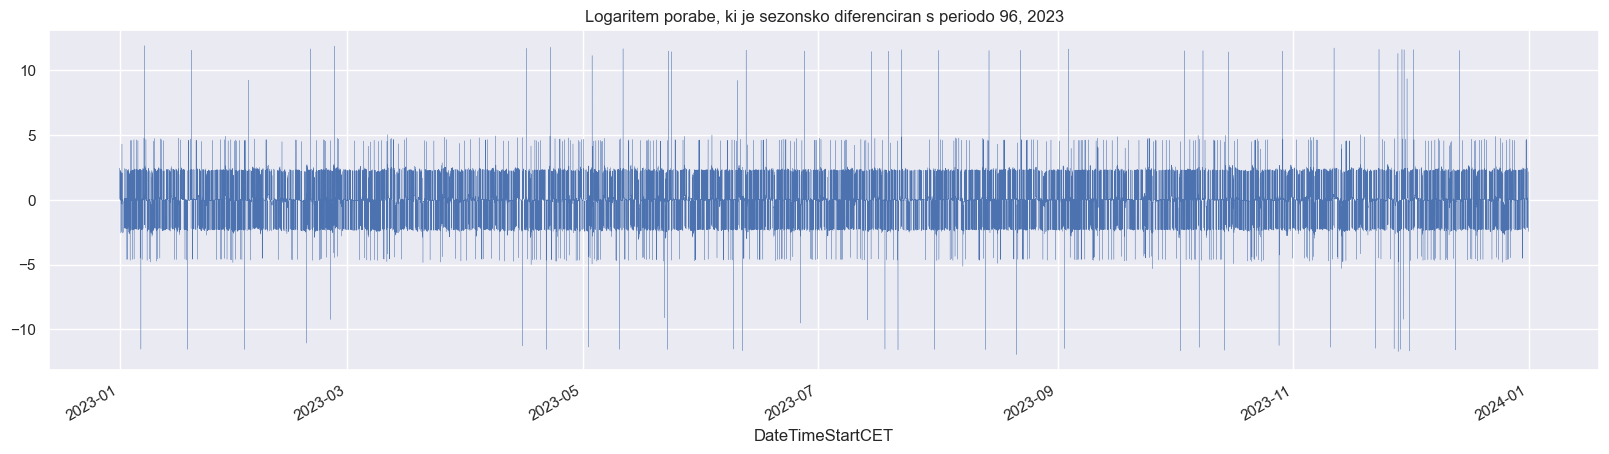

In [15]:
ts_diff = podatki['Logaritem'].diff(periods = 96)
ts_diff['2023'].plot(linewidth=0.2) 
plt.title('Logaritem porabe, ki je sezonsko diferenciran s periodo 96, 2023')

In [ ]:
# opazimo, da je časovna vrsta kar precej bolj stacionarna. Preverimo še ACF

Text(0.5, 1.0, 'ACF po prvem sezonskem diferenciranju, 2023')

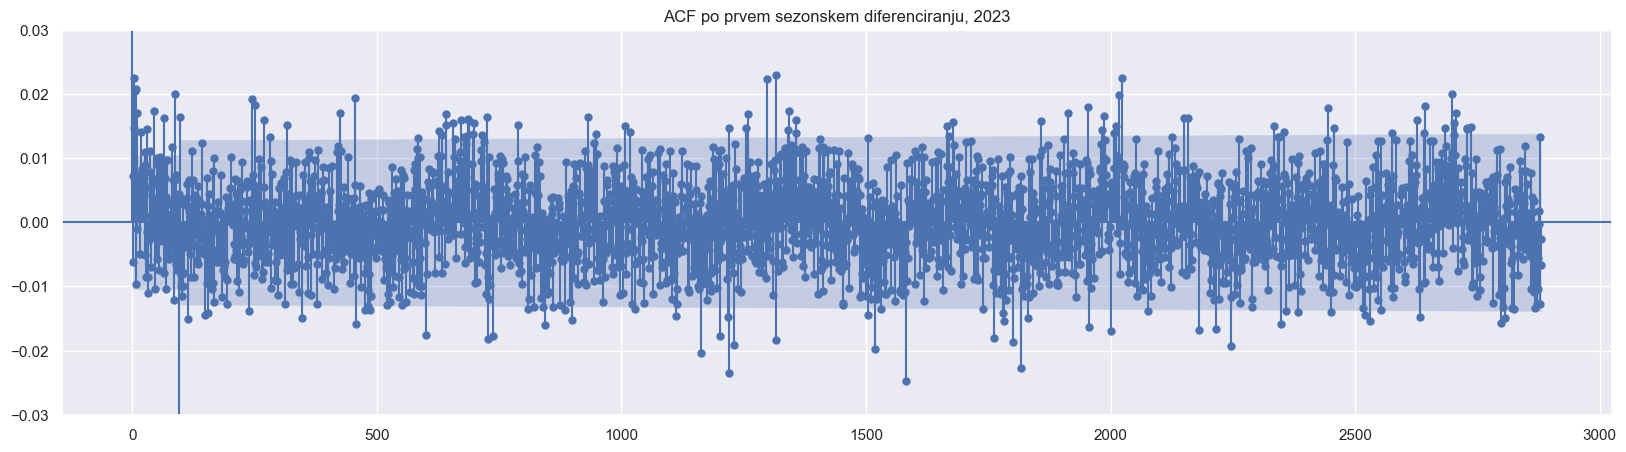

In [16]:
tsaplots.plot_acf(ts_diff['2023'], lags=2880)
plt.ylim(-0.03,0.03)
plt.title('ACF po prvem sezonskem diferenciranju, 2023')

In [ ]:
# zgleda stacionarno, ampak diferencirajmo še enkrat

Text(0.5, 1.0, 'Po drugem diferenciranju, 2023')

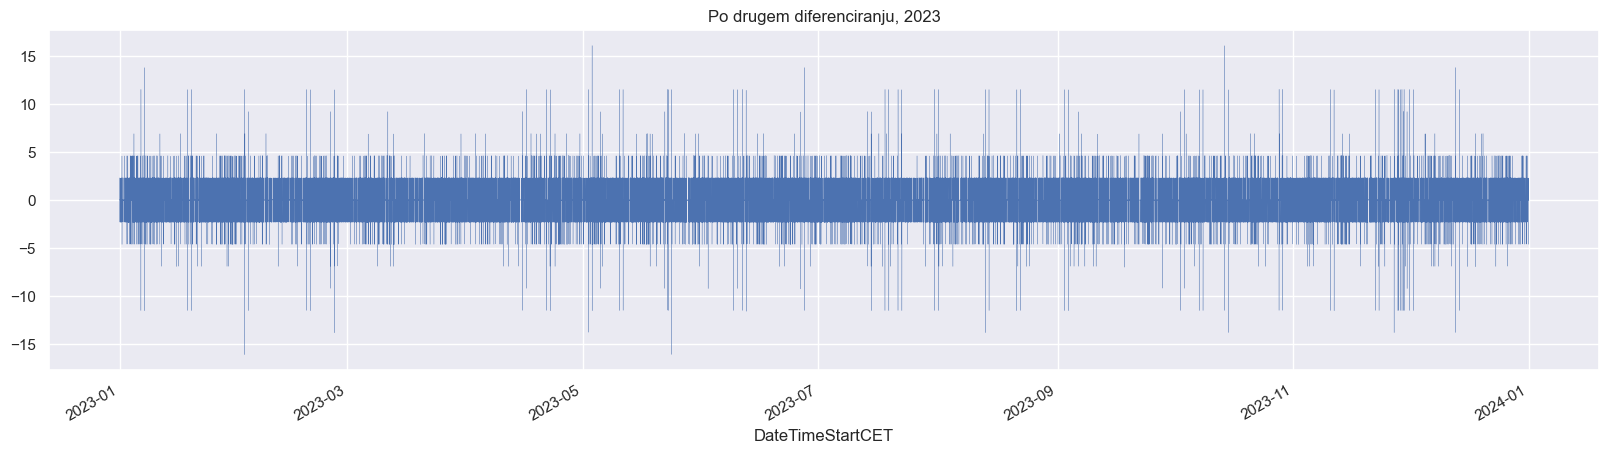

In [17]:
ts_diff2 = ts_diff.diff()
ts_diff2['2023'].plot(linewidth=0.2) 
plt.title('Po drugem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po drugem diferenciranju, 2023')

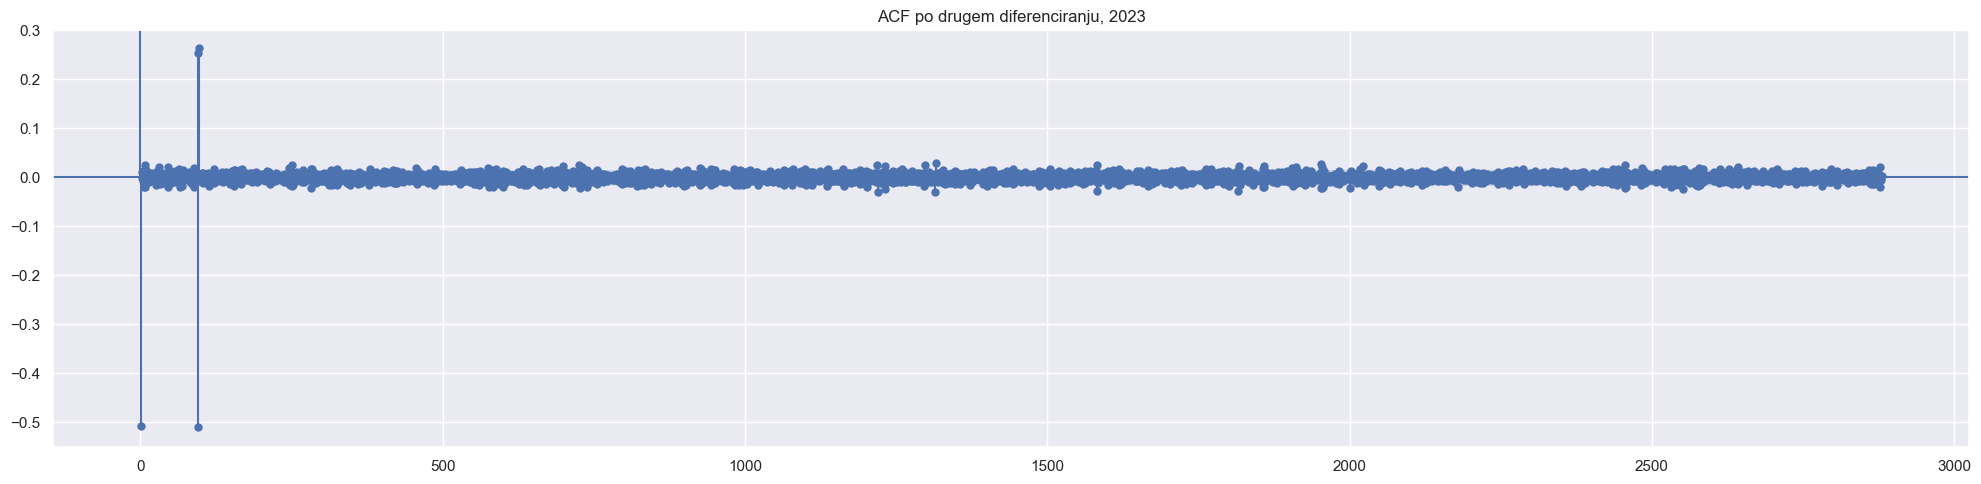

In [18]:
tsaplots.plot_acf(ts_diff2['2023'], lags=2880)
plt.ylim(-0.55,0.3)
plt.tight_layout()
plt.title('ACF po drugem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po drugem diferenciranju, zožen lag, 2023')

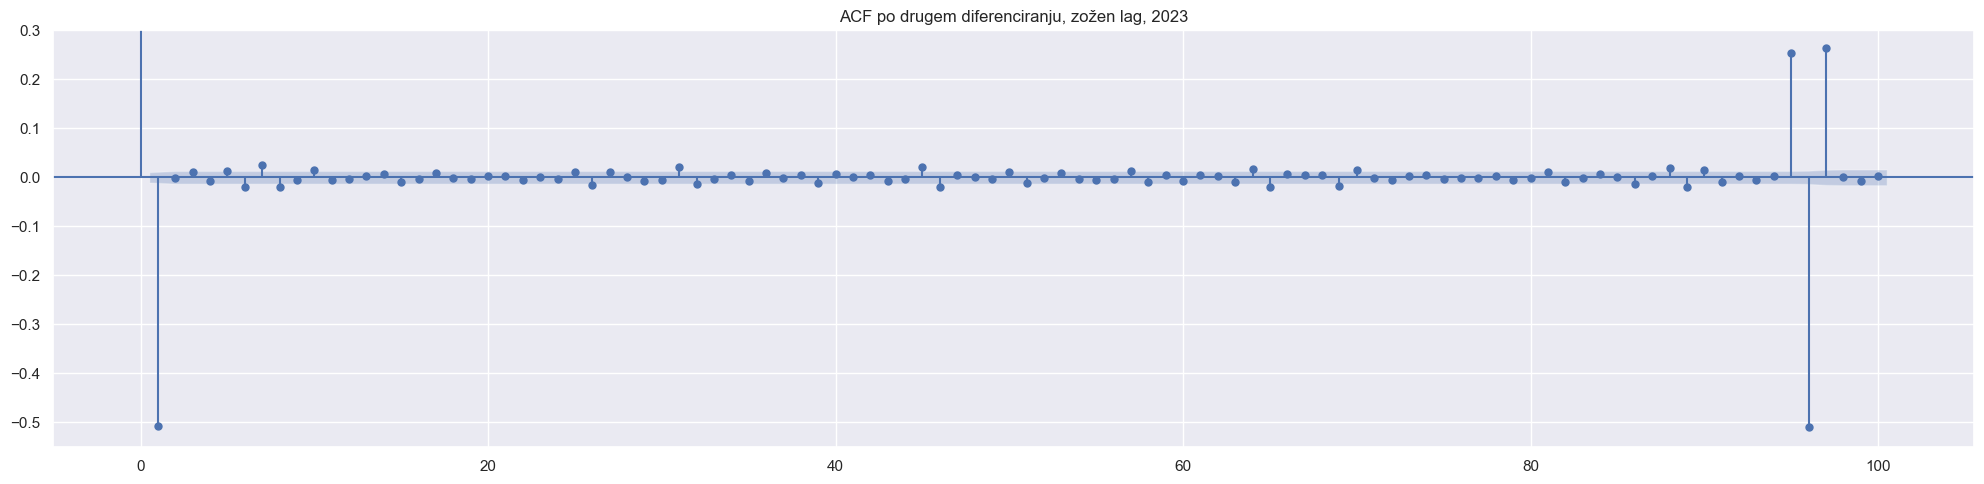

In [19]:
tsaplots.plot_acf(ts_diff2['2023'], lags=100)
plt.ylim(-0.55,0.3)
plt.tight_layout()
plt.title('ACF po drugem diferenciranju, zožen lag, 2023')

In [20]:
# sedaj zgleda še bolj stacionarno, torej je primerna za model ARMA

# iz ACF se visoko avtokorelacijo opazi pri: 1, 95, 96, 97

# RABIM FORMALNE TESTE?

import statsmodels.tsa.stattools as ts

def test_p_value(data):
        fuller_test = ts.adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Reject null hypothesis, data is stationary')
        else:
            print('Do not reject null hypothesis, data is not stationary')

test_p_value(ts_diff2.dropna())

P-value:  0.0
Reject null hypothesis, data is stationary


Text(0.5, 1.0, 'PACF po drugem diferenciranju, 2023')

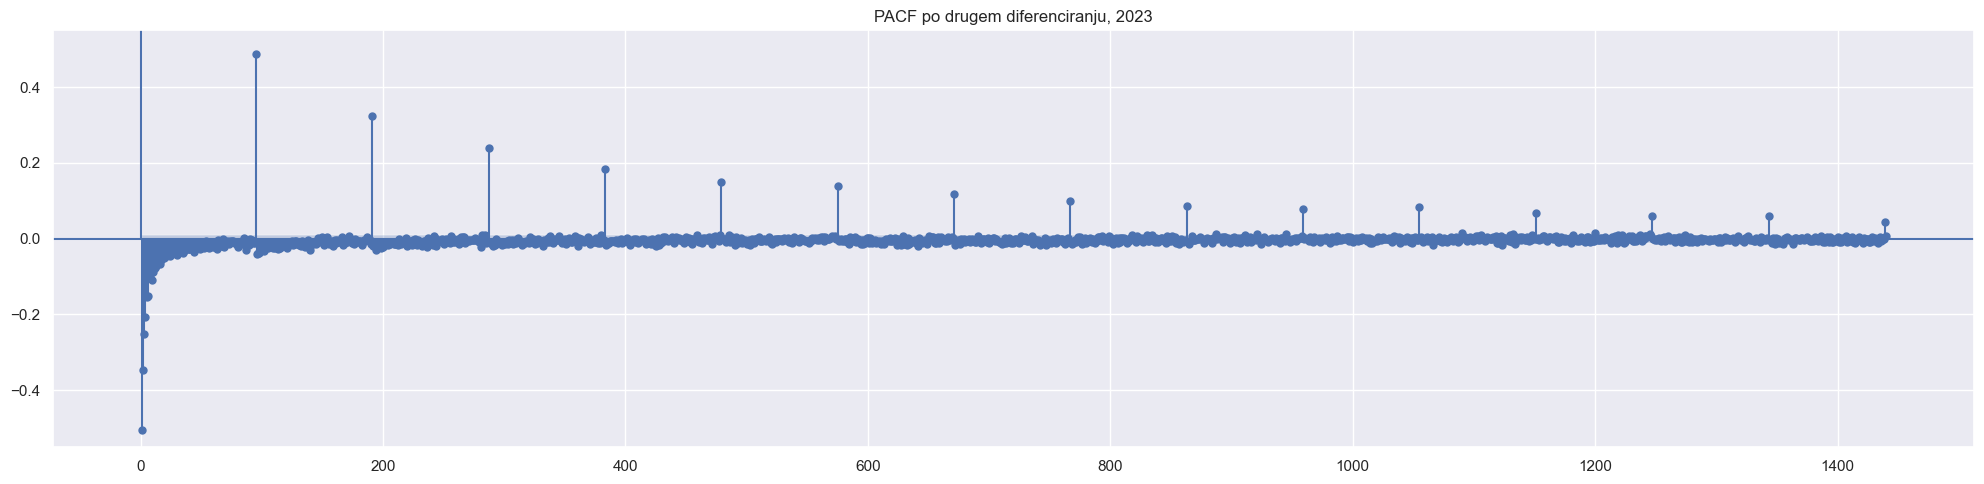

In [141]:
# zaradi izbire modelov si narišemo še PACF

tsaplots.plot_pacf(ts_diff2['2023'].values.squeeze(), lags=1440, method="ywm")
plt.ylim(-0.55,0.55)
plt.tight_layout()
plt.title('PACF po drugem diferenciranju, 2023')

Text(0.5, 1.0, 'PACF po drugem diferenciranju, zožen lag, 2023')

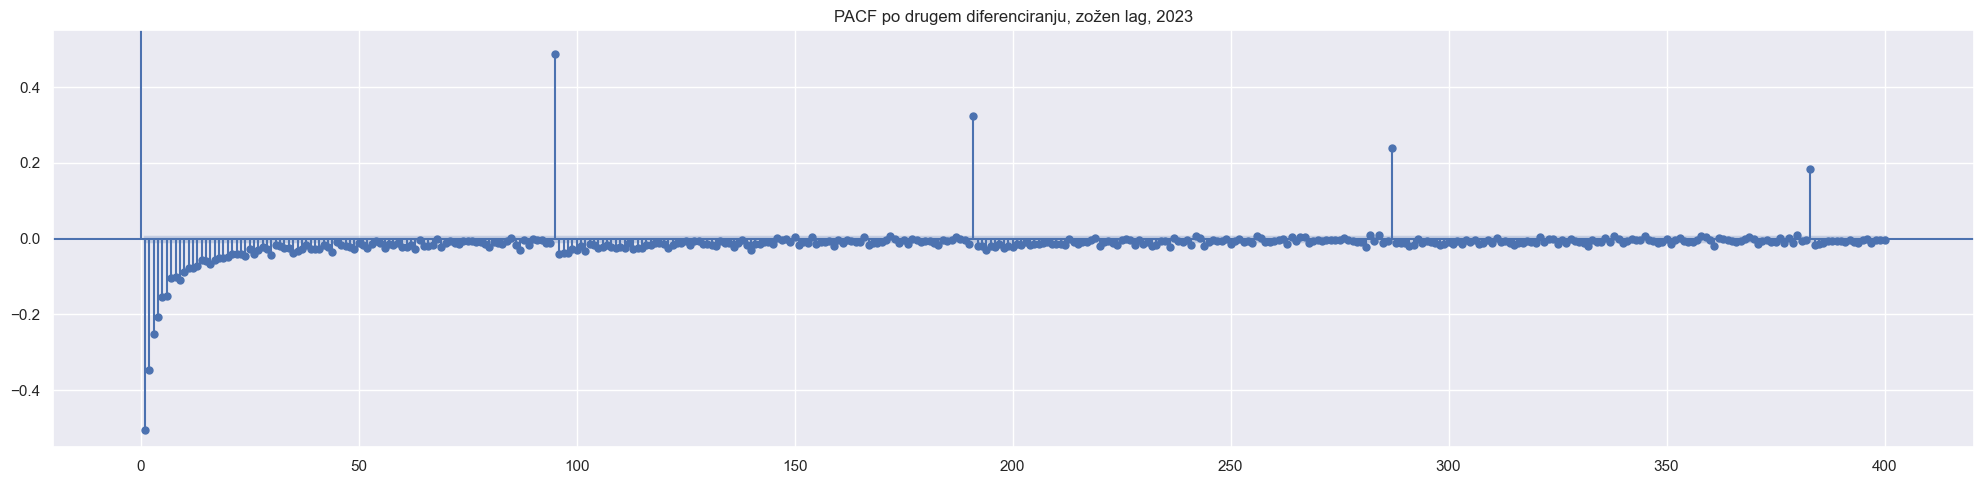

In [142]:
tsaplots.plot_pacf(ts_diff2['2023'].values.squeeze(), lags=400, method="ywm")
plt.ylim(-0.55,0.55)
plt.tight_layout()
plt.title('PACF po drugem diferenciranju, zožen lag, 2023')

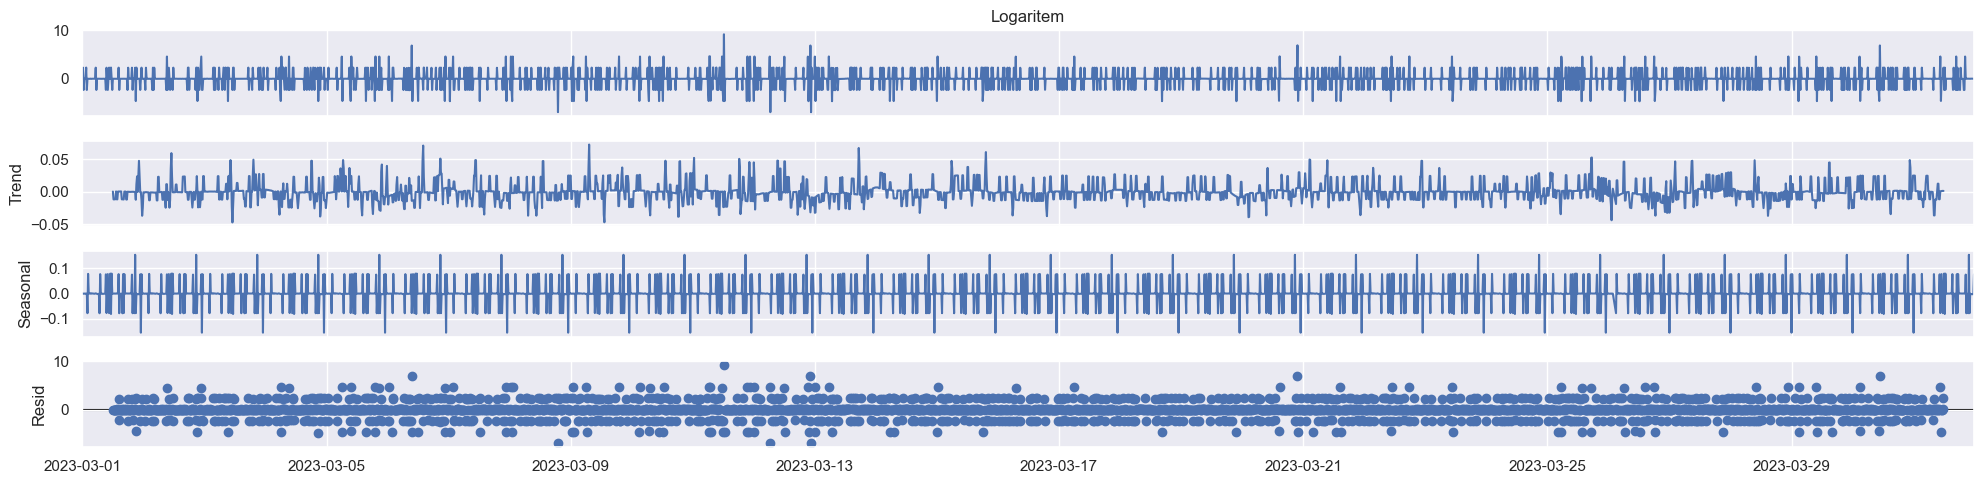

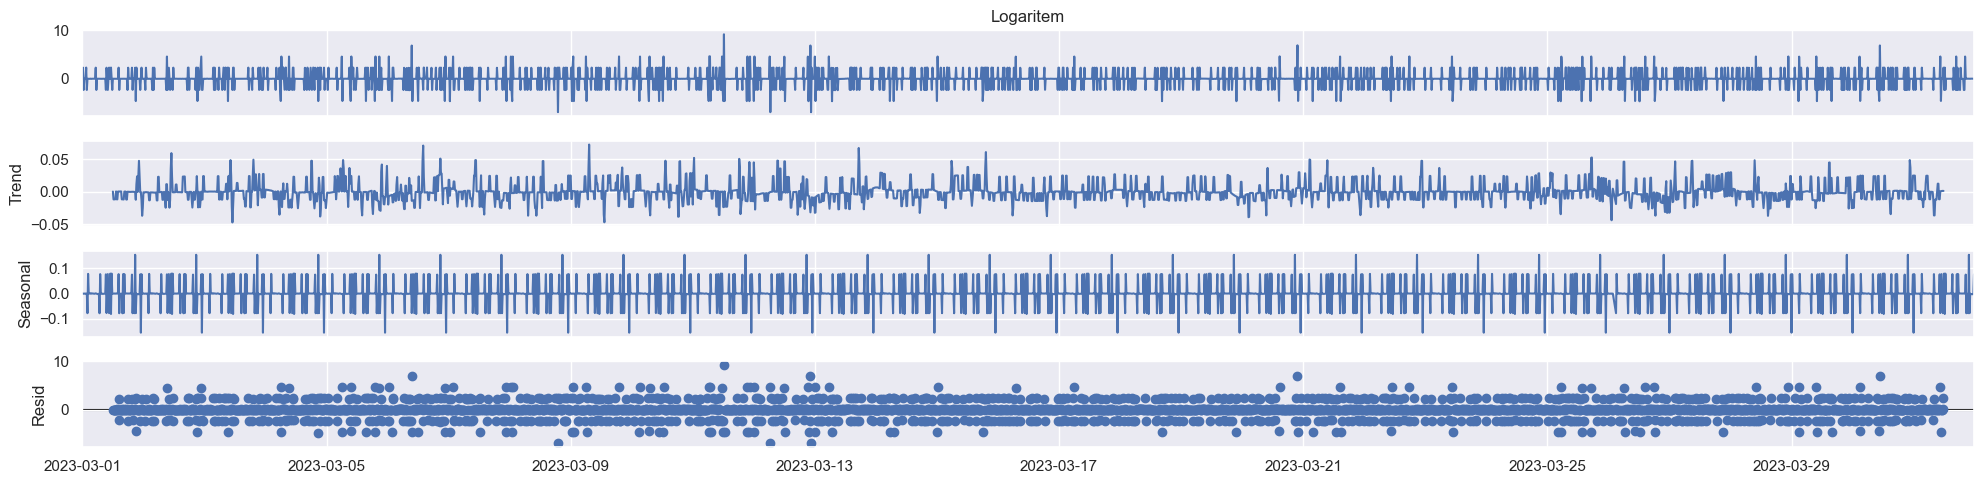

In [48]:
seasonal_decompose(ts_diff2['2023-03'].dropna(), model='additive', period=96).plot()

In [ ]:
# visoka korelacije je pri: 1, 2, 95, 191, se ponovi na 96

# PACF -> AR(p)
# ACF -> MA(q)


# ACF in PACF povesta katere log bi bilo potrebno vključiti
# Zagotovo bomo vključili prvih nekaj meritev/ur, ker imajo večji vpliv
# Koliko dodatnih log-ov bomo še vključili, pa se bomo odločili s pomočjo kriterija AIC

In [50]:
## MODELI

# da bo šlo bolj hitro se zaenkrat omejimo na samo na dva meseca:
# train data:
train_data = ts_diff2['2023-02-20':'2023-02-28']
train_data_OG = podatki.loc['2023-02-22':'2023-02-28', 'Odjem ACT']
# test data:
test_data = ts_diff2['2023-03-01']
test_data_OG = podatki.loc['2023-03-01', 'Odjem ACT']

In [ ]:
# uporabljam SARIMA ker imam sezonsko konponento

In [62]:
# # Constructing the ARIMA model

# from statsmodels.tsa.arima_model import ARIMA

# model = sm.tsa.statespace.SARIMAX(train_data, order=(0,1,0), seasonal_order=(1,1,1,96))
# results = model.fit()
# results.summary()

In [51]:
# Constructing the ARIMA model

from statsmodels.tsa.arima_model import ARIMA

model = sm.tsa.statespace.SARIMAX(train_data_OG, order=(0,1,0), seasonal_order=(1,1,1,96))
results = model.fit()
results.summary()

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Odjem ACT   No. Observations:                  672
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 96)   Log Likelihood                -626.021
Date:                              Sat, 11 May 2024   AIC                           1258.042
Time:                                      22:44:30   BIC                           1271.105
Sample:                                  02-22-2023   HQIC                          1263.136
                                       - 02-28-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L96       0.0352      0.073      0.483      0.629      -0.107       0.178
ma.S.L96      -0.9882      1.831     -0.540      0.589      -4.576       2.600
sigma2         0.3817      0.678      0.563      0.573      -0.946       1.710
===================================================================================
Ljung-Box (L1) (Q):                 141.32   Jarque-Bera (JB):               150.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.09
Prob(H) (two-sided):                  0.36   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
# Constructing the ARIMA model

from statsmodels.tsa.arima_model import ARIMA

model = sm.tsa.statespace.SARIMAX(train_data_OG, order=(1,1,1), seasonal_order=(1,1,1,96))
results = model.fit()
results.summary()

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Odjem ACT   No. Observations:                  672
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 96)   Log Likelihood                -453.516
Date:                            Sat, 11 May 2024   AIC                            917.033
Time:                                    22:56:26   BIC                            938.804
Sample:                                02-22-2023   HQIC                           925.524
                                     - 02-28-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0181      0.040      0.448      0.654      -0.061       0.097
ma.L1         -0.9281      0.014    -66.218      0.000      -0.956      -0.901
ar.S.L96      -0.0112      0.062     -0.181      0.856      -0.133       0.110
ma.S.L96      -0.9918      2.690     -0.369      0.712      -6.265       4.281
sigma2         0.2053      0.542      0.379      0.705      -0.857       1.268
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               310.57
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -1.17
Prob(H) (two-sided):                  0.64   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
# Constructing the ARIMA model

from statsmodels.tsa.arima_model import ARIMA

model = sm.tsa.statespace.SARIMAX(train_data_OG, order=(6,1,1), seasonal_order=(1,1,1,96))
results = model.fit()
results.summary()

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Odjem ACT   No. Observations:                  672
Model:             SARIMAX(6, 1, 1)x(1, 1, 1, 96)   Log Likelihood                -452.416
Date:                            Sat, 11 May 2024   AIC                            924.832
Time:                                    23:15:26   BIC                            968.375
Sample:                                02-22-2023   HQIC                           941.814
                                     - 02-28-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0235      0.051     -0.461      0.645      -0.123       0.076
ar.L2         -0.0227      0.049     -0.463      0.644      -0.119       0.073
ar.L3         -0.0264      0.049     -0.542      0.588      -0.122       0.069
ar.L4         -0.0728      0.051     -1.438      0.150      -0.172       0.026
ar.L5         -0.0422      0.046     -0.912      0.362      -0.133       0.049
ar.L6         -0.0414      0.050     -0.835      0.404      -0.139       0.056
ma.L1         -0.8875      0.032    -27.993      0.000      -0.950      -0.825
ar.S.L96      -0.0065      0.063     -0.102      0.919      -0.131       0.118
ma.S.L96      -0.9953      4.731     -0.210      0.833     -10.267       8.276
sigma2         0.2041      0.956      0.214      0.831      -1.669       2.077
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               313.77
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -1.16
Prob(H) (two-sided):                  0.64   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot: xlabel='DateTimeStartCET'>

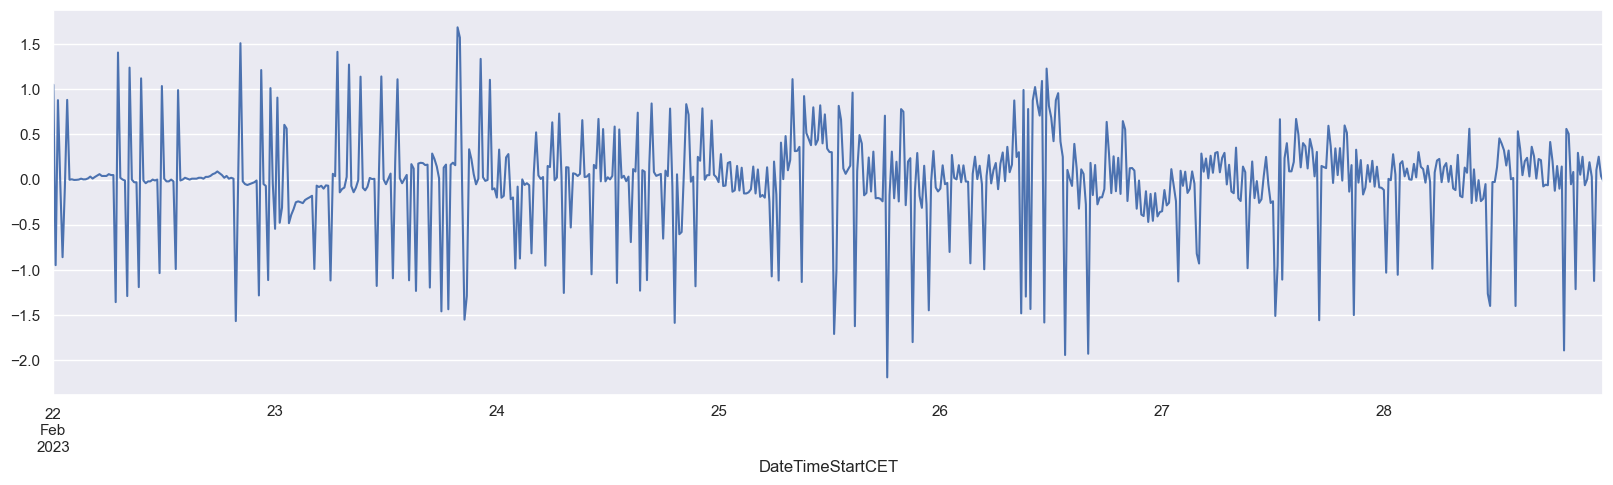

In [68]:
results.resid.plot()

Text(0.5, 1.0, 'PACF za SARIMAX, 2023')

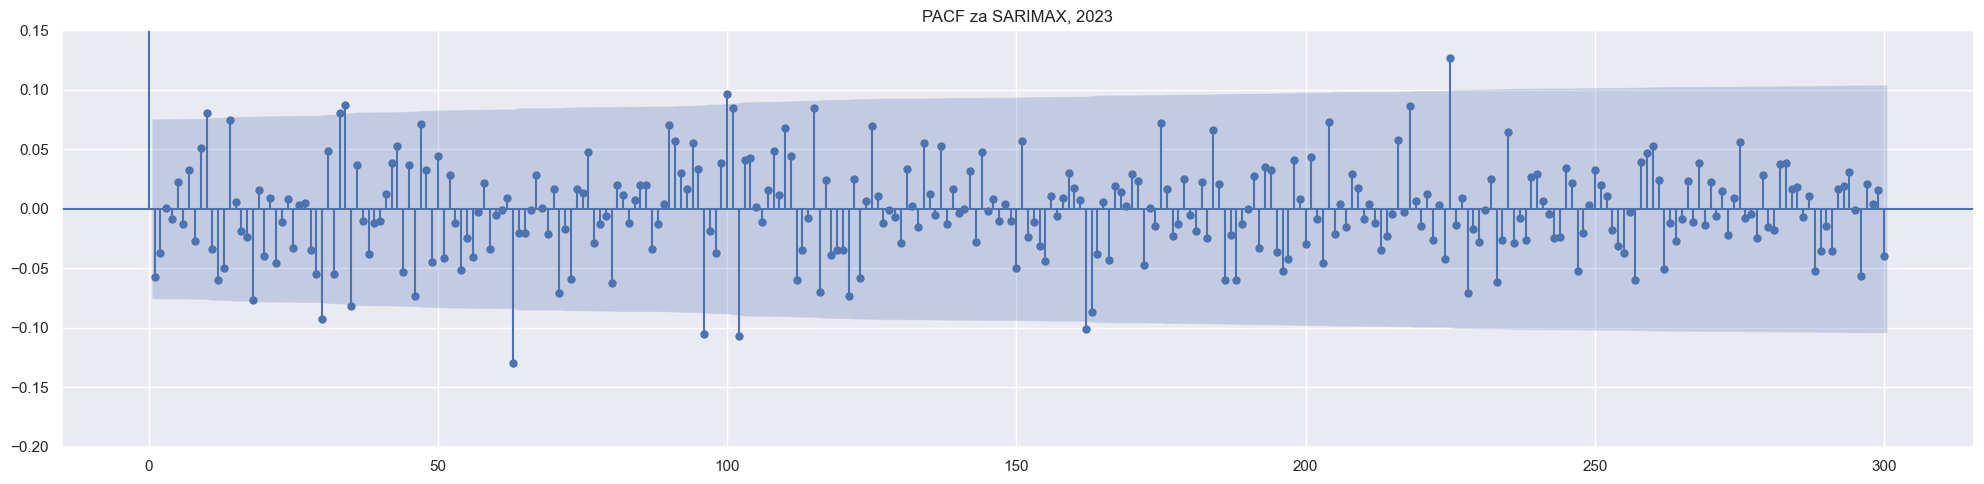

In [69]:
tsaplots.plot_acf(results.resid.values.squeeze(), lags=300)
plt.ylim(-0.2,0.15)
plt.tight_layout()
plt.title('PACF za SARIMAX, 2023')

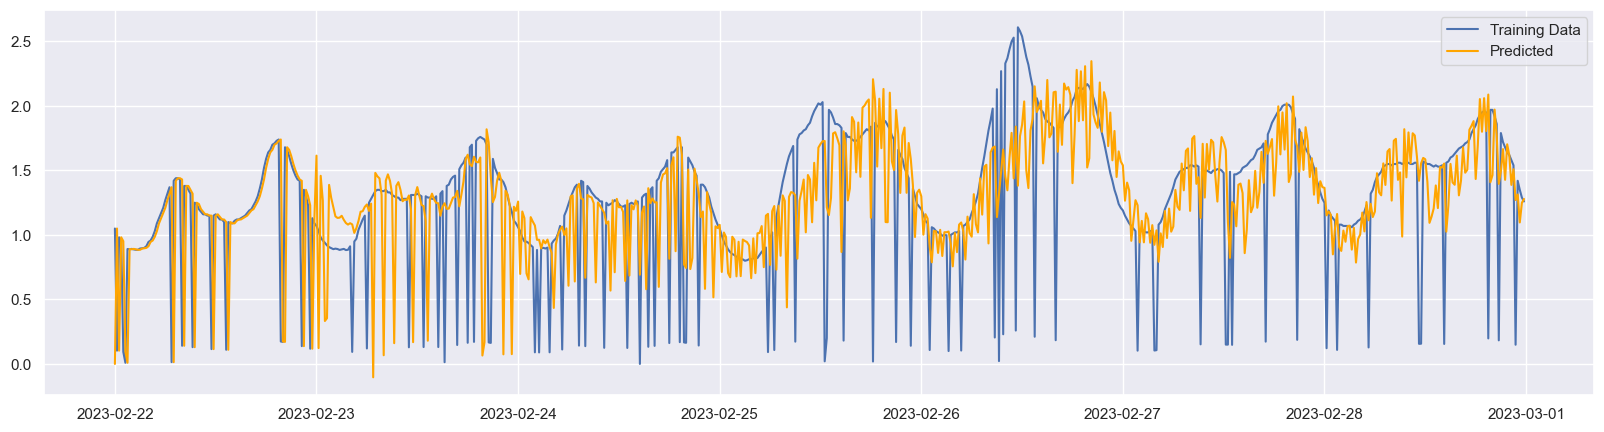

In [72]:
# df['prediction'] = 
results.predict()
# >>> df[['Production','prediction']].plot(figsize=(12,8))

plt.plot(train_data_OG, label='Training Data')
plt.plot(results.predict(), label='Predicted', color='orange')
plt.legend()

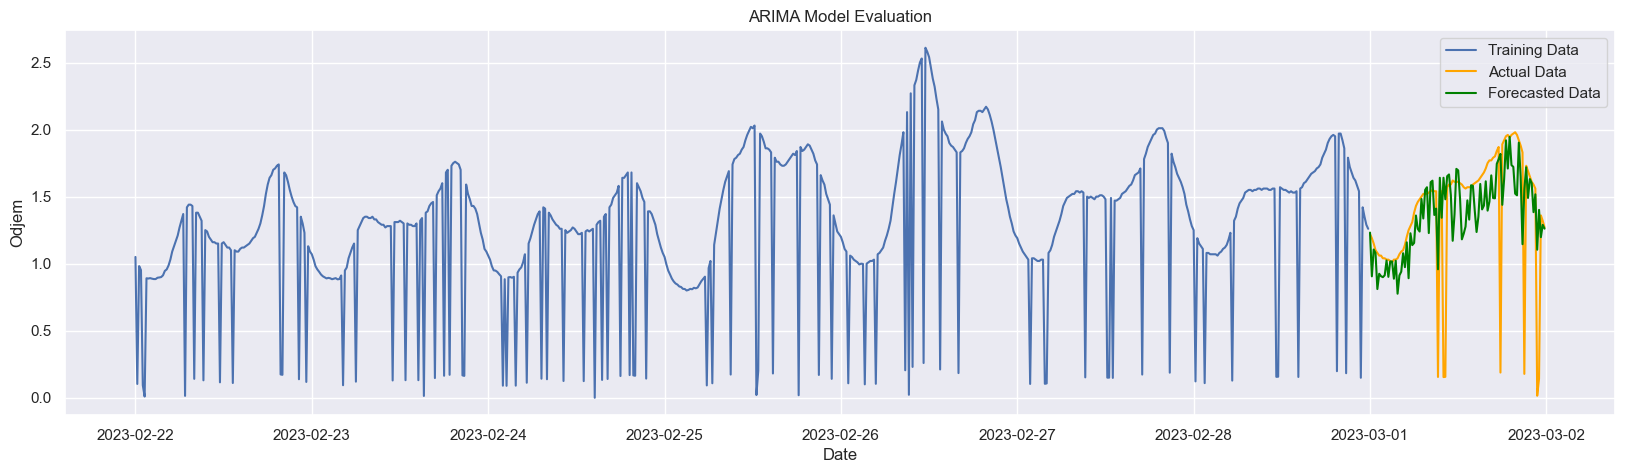

In [74]:
# FORECAST on the test dataset
test_forecast = results.get_forecast(steps=96)
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test_data.index)

# narišemo
plt.plot(train_data_OG, label='Training Data')
plt.plot(test_data_OG, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Odjem')
plt.legend()
plt.show()